# Inicialización de R

In [ ]:
R.version.string

[1] "R version 4.0.4 (2021-02-15)"

## Instalación de paquetes

* `openxlsx` Para manejo de archivos `.xlsx`.
* `dplyr` Para hacer uso de la función `filter`. 

In [ ]:
#install.packages("rgl", repos = "http://cran.rstudio.com/")

# Manejo de archivos .xlsx
if("openxlsx" %in% rownames(installed.packages()) == FALSE) {install.packages("openxlsx")}
# SOM
if("kohonen" %in% rownames(installed.packages()) == FALSE) {install.packages("kohonen")}
# Funcion filter
if("dplyr" %in% rownames(installed.packages()) == FALSE) {install.packages("dplyr")}
# ISOMAP
if("vegan" %in% rownames(installed.packages()) == FALSE) {install.packages("vegan")}
# LLE
if("lle" %in% rownames(installed.packages()) == FALSE) {install.packages("lle")}

# Conjunto de Datos
Trabajamos en este ejercicio con los datos del sitio: 

    https://data.humdata.org/dataset/survey-on-gender-equality-at-home

Nos limitamos a la parte del cuestionario sobre la pregunta:

    D.6. As a result of the coronavirus (COVID-19) pandemic, did you personally experience any of the following?
    1. Unable to seek medical care 
    2. Isolate or follow a quarantine order
    3. Lost a job 
    4. Difficulty accessing medical or hygiene supplies
    5. Migrated to different geographical area 
    6. None of the above
    7. Other
    8. Unable to perform usual personal care/health routines
    9. School was cancelled or reduced
    10. Lost access to/could not use public transport
    11. Longer wait times to visit doctors/seek medical care 

Cada observación es entonces un vector de dimensión 11. Estudiamos las respuestas agregadas a nivel de país. __Nos limitamos a las respuestas de los hombres__. Usaremos herramientas vistas en clase para entender mejor la estructura de este (sub)conjunto de datos.

### Lectura de datos
El archivo `sog_agg_country.xlsx` es contiene tres hojas de cálculo: 

1. `Readme`: Información importante sobre este conjunto de datos y preguntas frecuentes.
2. `Codebook`: Descripción de variables de este conjunto de datos.  
3. `Data`: Conjunto de datos. Las respuestas agregadas a nivel de país.

Leemos el archivo y nos quedamos con la tercera hoja de cálculo.

In [ ]:
# 0. Libreria para manejo de archivos .xlsx
library("openxlsx")

# 1. Tomamos la tercera hoja de calculo.
data <- read.xlsx("sog_agg_country.xlsx", sheet = 3)
# 1.1. Observamos algunos de nuestros datos.
head(data, 5)

,Year,Region,Country,Internet_Penetration,Gender,a1_agree,a1_neutral,a1_disagree,a2_opps_other,a3_yes,⋯,d6_wait,d7_bored,d7_food,d7_health,d7_info,d7_loan,d7_money,d7_none,d7_stuck,d7_work
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020,North America,Canada,95 to 100%,Female,93,1,5,7.40,54,⋯,33,30,30,33,33,19,35,7,37,32
2,2020,North America,Canada,95 to 100%,Male,92,2,5,7.62,59,⋯,31,31,28,26,29,19,33,6,35,36
3,2020,North America,Canada,95 to 100%,Combined,93,2,5,7.55,56,⋯,32,31,29,30,31,19,34,6,36,34
4,2020,North America,United States of America,70 to 75%,Female,90,3,7,7.42,50,⋯,36,32,34,28,42,17,39,7,37,33
5,2020,North America,United States of America,70 to 75%,Male,89,4,8,7.88,64,⋯,28,27,28,25,40,17,33,8,32,35


In [ ]:
unique(data$Region)

[1] "North America"                "East Asia & Pacific"         
[3] "South Asia"                   "Latin America and Caribbean" 
[5] "Middle East and North Africa" "Europe and Central Asia"     
[7] "Sub-Saharan Africa"

__¿Cómo se calculan las estadísticas a nivel de país?__ Las estadísticas a nivel de país proporcionadas reflejan el porcentaje de encuestados en cada país / región que dan una respuesta determinada a cada pregunta. Estos porcentajes se calculan en función de todas las personas que respondieron a una pregunta determinada (incluso si su respuesta es "No sé" o "Prefiero no responder"). Luego, estos porcentajes se calibran para proporcionar estimaciones que representan la población en línea (¿?) en cada país y luego se desglosan para hombres y mujeres. Los pesos se aplicaron a nivel de encuestado individual antes de la agregación.

### Elección de variables
Nos limitamos a las respuestas de los hombres y tomamos en cuenta sólo las variables

    d6_health, d6_isolate, d6_job, d6_medical, d6_migrate, d6_none, d6_other, d6_personal, d6_school, d6_transport, d6_wait

In [ ]:
# 0. Libreias para manejo de dataframes.
library("dplyr")

# 1. Filtramos para quedarnos con las respuestas de los hombres.
data_male <- filter(data, Gender == "Male")
# 2. Ahora nos quedamos solo con las variables de interes.
X <- select(data_male, d6_health:d6_wait)
# 3. A cada observacion le asigno de nombre su país sorrespondiente
rownames(X) <- data_male$Country
head(X)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Canada,16,35,20,23,6,24,6,13,27,9,31
United States of America,17,40,17,24,4,27,5,12,26,9,28
Australia,18,36,15,20,3,28,5,9,22,13,25
Cambodia,17,11,41,17,10,15,11,5,39,19,8
Indonesia,14,18,44,8,3,16,9,5,29,18,9
Japan,5,27,7,44,2,30,8,3,12,7,8


### Algunas observaciones iniciales


#### Valores faltantes y cantidad de observaciones
* Se tienen $123$ observaciones de dimensióón $11$.
* No hay valores faltantes.

In [ ]:
# 1. Obtenemos N y d, la cantidad de datos y su dimension
N <- dim(X)[1]
d <- dim(X)[2]
print(c(N, d))
# 2. Observamos datos con valores faltantes (En este caso no)
X[!complete.cases(X),]

[1] 123  11


d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


#### Medias

* Media mínima en variable `d6_other` con un valor de $9.39$, es decir, en promedio el $7.52\%$ de hombres experimentaron otros fenomenos (resultantes de la pandemia) diferentes a los usados en el cuestionario.
* Media máxima en variable `d6_school` con un valor de $30.71$, es decir, en promedio el $30.71\%$ de hombres canceló o redujo el tiempo de escuela.
* Ordenadas de menor a mayor: `d6_other`, `d6_migrate`, `d6_health`, `d6_personal`, `d6_medical`, `d6_wait`, `d6_none`, `d6_transport`, `d6_job`, `d6_isolate`, `d6_school`.

Observemos que el promedio de la proporción de hombres que experimentaron otros fenomenos (resultantes de la pandemia) diferentes a los usados en el cuestionario es el más bajo.

Por otro lado, el promedio de la proporción de hombres cuyas actividades escolares se vieron afectadas fué el mayor.

In [ ]:
# 1. Calculamos medias de cada variable
means <- t(as.matrix(colMeans(X)))
print("Medias")
round(means, 2)

[1] "Medias"


d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
17.1,28.32,24.34,18.41,9.39,20.8,7.52,12.21,30.72,23.18,18.73


#### Varianzas

* Varianza mínima en variable `d6_other` con un valor de $4.6$.
* Varianza máxima en variable `d6_school` con un valor de $167.81$.
* Ordenadas de menor a mayor son: `d6_other`, `d6_migrate`, `d6_personal`, `d6_health`, `d6_medical`, `d6_wait`, `d6_none`, `d6_job`, `d6_transport`, `d6_isolate`, `d6_school`.

Notemos que la proporción de hombres que experimentaron otros fenomenos (resultantes de la pandemia) diferentes a los usados en el cuestionario tiene la menor variación entre países, mientras  que la proporción de hombres cuyas actividades escolares fueron afectadas tiene la mayor variación entre países.

De aquí podemos decir que la proporción de hombres afectados en actividades escolares varía mucho de país en país, esto se puede deber, por ejemplo, a que los países tomaron diferentes medidas respecto a actividades escolares, o bien, los países tienen diferentes proporciones de hombres entrevistados con actividades escolares.

Tambien podemos decir que la proporción de hombres que experimentaron otros fenomenos (resultantes de la pandemia) diferentes a los usados en el cuestionario es parecida en todos los países.

In [ ]:
# 2. Calculamos varianzas de cada variable
vars <- t(as.matrix(diag(var(X))))
print("Varianzas")
round(vars, 2)

[1] "Varianzas"


d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
36.02,135.81,96.8,45.54,27.55,86.06,4.6,36.73,167.81,129.36,54.59


Entonces, a partir de observar la media y varianza de cada variable, podemos decir que

* La proporción de hombres que experimentaron otros fenomenos (resultantes de la pandemia) diferentes a los usados en el cuestionario es __baja y parecida para todos los países__.

* La proporción de hombres afectados en actividades escolares __varía de país en país pero en promedio es alta__.

#### Correlación

* Coeficiente de correlación de `d6_none` es negativo para todas las variables, excepto con la variable `d6_other`. Esto tiene sentido pues si la proporción de hombres que experimentaron alguno de los fenomenos considerados en el cuestionario crece, entonces la proporción de hombres que no esperimentaron ninguno de estos disminuye. Por otro lado, podemos notar que hay un poco de correlación positiva entre `d6_none` y `d6_other`, pues si un hombre no experimenta alguno de los fenomenos considerados en el cuestionario todavíía queda la posibilidad de que haya experimenado otra clase de fenomenos derivados de la pandemia.
* 
* Coeficiente de correlación menor a $-0.7$ en parejas
    * `d6_job` y `d6_none` con un coeficiente de $-0.76$.
    * `d6_none` y `d6_school` con un coeficiente de $-0.71$.
    * `d6_none` y `d6_transport` con un coeficiente de $-0.71$.
* Coeficiente de correlación mayor a $0.6$ en parejas
    * `d6_health` y `d6_personal` con un coeficiente de $0.61$.
    * `d6_transport` y `d6_job` con un coeficiente de $-0.62$.
    * `d6_medical` y `d6_personal` con un coeficiente de $-0.60$.

In [ ]:
# 3. Calculamos coeficientes de correlacion
print("Matriz de Correlacion")
round(cor(X), 2)

[1] "Matriz de Correlacion"


,d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
d6_health,1.00,0.52,0.57,0.50,0.16,-0.70,-0.13,0.61,0.38,0.55,0.52
d6_isolate,0.52,1.00,0.28,0.46,-0.09,-0.33,-0.17,0.44,-0.11,0.18,0.56
d6_job,0.57,0.28,1.00,0.21,0.30,-0.77,0.06,0.31,0.43,0.62,-0.01
d6_medical,0.50,0.46,0.21,1.00,-0.02,-0.36,-0.10,0.61,0.11,0.34,0.47
d6_migrate,0.16,-0.09,0.30,-0.02,1.00,-0.55,-0.08,0.08,0.52,0.43,-0.30
d6_none,-0.70,-0.33,-0.77,-0.36,-0.55,1.00,0.18,-0.45,-0.71,-0.71,-0.12
d6_other,-0.13,-0.17,0.06,-0.10,-0.08,0.18,1.00,-0.15,-0.30,-0.08,-0.27
d6_personal,0.61,0.44,0.31,0.61,0.08,-0.45,-0.15,1.00,0.16,0.44,0.57
d6_school,0.38,-0.11,0.43,0.11,0.52,-0.71,-0.30,0.16,1.00,0.48,-0.06
d6_transport,0.55,0.18,0.62,0.34,0.43,-0.71,-0.08,0.44,0.48,1.00,0.05


# Visualización de datos

## Graficas por parejas de variables
* Dependencia lineal en algunas parejas de variables.
* Presencia de datos atípicos.
* Cierta separación entre países de diferentes regiones.

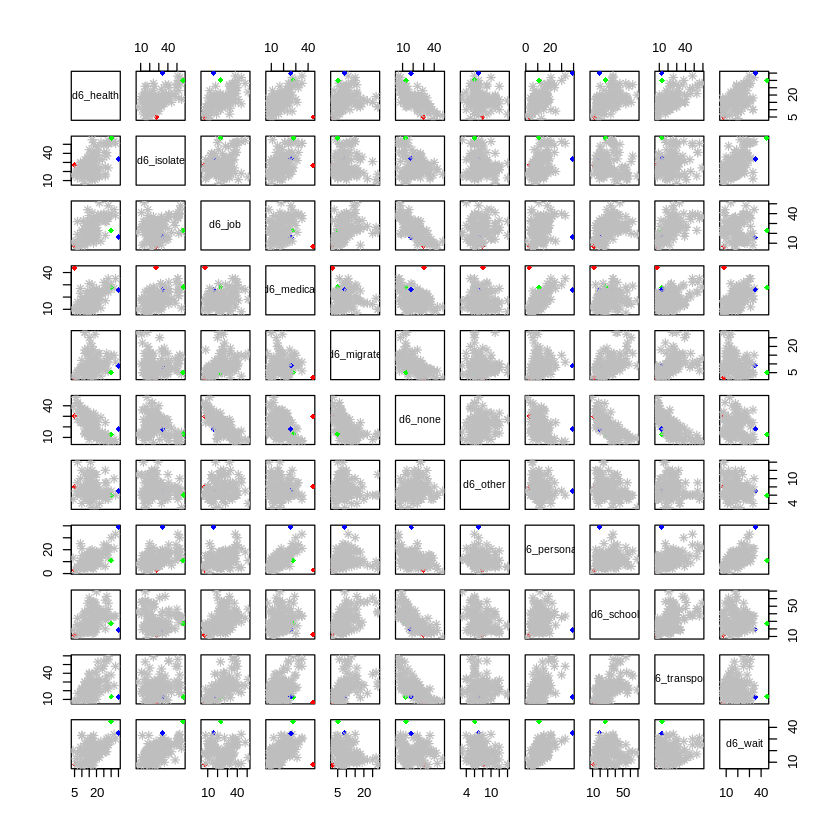

In [ ]:
panel.hist <- function(x, ...) {
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(usr[1:2], 0, 1.5) )
    h <- hist(x, plot = FALSE)
    breaks <- h$breaks; nB <- length(breaks)
    y <- h$counts; y <- y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y, col="grey", ...)
}

group <- NA
group[data_male$Country == "Japan"] <- 1
group[data_male$Country == "Lithuania"] <- 2
group[data_male$Country == "Puerto Rico"] <- 3
group[data_male$Country != "Japan" & data_male$Country != "Lithuania" & data_male$Country != "Puerto Rico"] <- 4

pairs(
    X, col = c("red", "blue", "green","gray")[group],
    pch = c(18, 18, 18, 8)[group]
)

### Regiones
Los países del mundo se pueden dividir en 7 regiones diferentes. Al graficar usando cada pareja de variables, y viendo las gráficas por filas notamos

* Países pertenecientes a la region de Latinoamerica y el caribe (Puntos en verde) se acumulan en la parte superior de las gráficas (Viendo por columna) relacionadas con las variables `d6_health` hasta `d6_medical`, por lo que la proporción de hombres que experimentaron alguno de los fenomenos relacionados con atención médica, aislamineto, trabajo y subministros médicos es alta. Por otro lado, estos países se acumulan en la parte inferior de las gráficas relacionadas con `d6_none`.
* Países pertenecientes a la region de Europa y Asia Central (Puntos rosas) se acumulan en la parte superior de las gráficas relacionadas con las variables `d6_none`, por lo que en región del mundo, la proporción de hombres que no experimentaron los primeros 5 fenomenos derivados de la pandemia en cada país es alta. Por otro lado, estos países se acumulan en la parte inferior de las gráficas relacionadas con la variable `d6_school`
* Países pertenecientes a la región de Africa Sub-Sahara (Puntos cafes) se acumulan en la parte superior de las gráficas relacionadas con la variable `d6_migrate`.

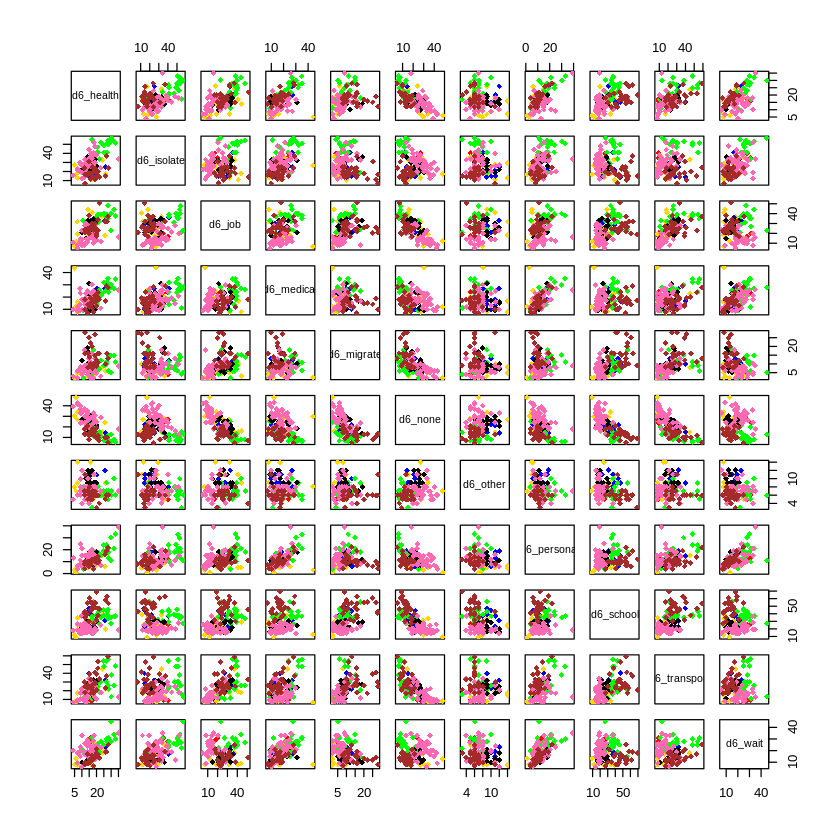

In [ ]:
group <- NA
group[data_male$Region == "North America"] <- 1
group[data_male$Region == "East Asia & Pacific"] <- 2
group[data_male$Region == "South Asia"] <- 3
group[data_male$Region == "Latin America and Caribbean"] <- 4
group[data_male$Region == "Middle East and North Africa"] <- 5
group[data_male$Region == "Europe and Central Asia"] <- 6
group[data_male$Region == "Sub-Saharan Africa"] <- 7

pairs(
    X, 
    col = c("red", "gold", "blue","green", "black", "hotpink", "brown")[group],
    pch = c(18, 18, 18, 18, 18, 18, 18)[group]
)

### Datos Atípicos
Se observa la presencia de datos atípicos en todas las graficas (Por renglón) relacionadas con
    
* `d6_medical`: __Japón__ (Punto Rojo) tiene la proporción más alta de hombres que tuvieron dificultades para tener acceso a subministros medicos, pero la proporción de hombres en las otras opciones es bajo.
* `d6_personal`: __Lithuania__ (Punto Azul) tiene la proporción más alta de hombres que tuvieron dificultades para continuar con sus  rutinas de cuidado personal / salud. Al graficar en el eje y `d6_personal` y en el eje x las demás variables notamos que los puntos se acumulan en la parte baja, mientras que __Lithuania__ se aleja en la parte superior. Además tiene la proporción más alta de hombres con dificultades para conseguir subministros medicos (`d6_health`).
* `d6_wait`. __Puerto Rico__ (Punto Verde) tiene la proporción más alta de hombres que tuvieron tiempos de espera más prolongados para visitar médicos / buscar atención médica. Al graficar en el eje y `d6_personal` y en el eje x las demás variables notamos que los puntos se acumulan en la parte baja, mientras que __Puerto Rico__ se aleja en la parte superior.


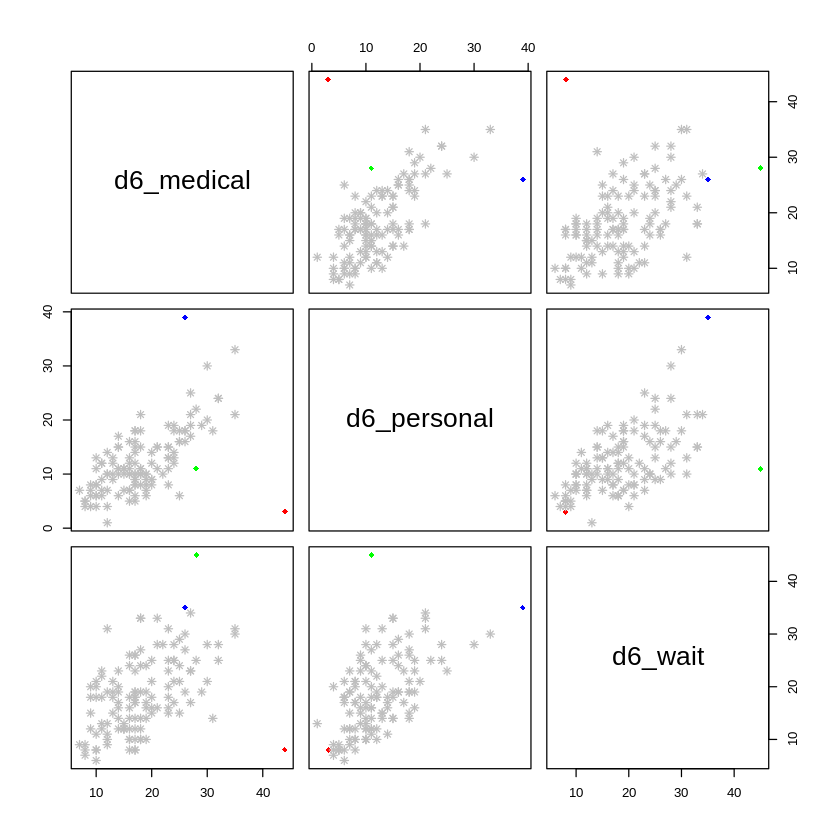

In [ ]:
group <- NA
group[data_male$Country == "Japan"] <- 1
group[data_male$Country == "Lithuania"] <- 2
group[data_male$Country == "Puerto Rico"] <- 3
group[data_male$Country != "Japan" & data_male$Country != "Lithuania" & data_male$Country != "Puerto Rico"] <- 4

pairs(
    select(X, c(d6_medical, d6_personal, d6_wait)),
    col = c("red", "blue", "green","gray")[group],
    pch = c(18, 18, 18, 8)[group]
)

In [ ]:
outlier <- filter(X, d6_medical == max(X$d6_medical))
outlier

outlier <- filter(X, d6_personal == max(X$d6_personal))
outlier

outlier <- filter(X, d6_wait == max(X$d6_wait))
outlier

,d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Japan,5,27,7,44,2,30,8,3,12,7,8


,d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lithuania,35,34,16,26,9,18,7,39,19,13,35


,d6_health,d6_isolate,d6_job,d6_medical,d6_migrate,d6_none,d6_other,d6_personal,d6_school,d6_transport,d6_wait
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Puerto Rico,30,57,23,28,5,13,6,11,27,13,45


## Análisis de Componentes Principales
Obtenemos las Componentes Principales con datos centrados y normalizados.

#### Proporción de Varianza explicada por cada Componente Principal

* Con las primeras $5$ componentes se logra explicar un $84\%$ de la varianza

In [ ]:
# 1. Calculo de componentes principales a partir de la matriz de correlacion.
pca <- princomp(X , cor = TRUE)
summary(pca)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4     Comp.5
Standard deviation     2.1194148 1.5420995 1.0751649 0.84185156 0.75899385
Proportion of Variance 0.4083563 0.2161883 0.1050891 0.06442855 0.05237015
Cumulative Proportion  0.4083563 0.6245445 0.7296336 0.79406215 0.84643230
                           Comp.6     Comp.7    Comp.8     Comp.9    Comp.10
Standard deviation     0.68880346 0.65202447 0.5516425 0.46368066 0.43530478
Proportion of Variance 0.04313184 0.03864872 0.0276645 0.01954543 0.01722639
Cumulative Proportion  0.88956414 0.92821286 0.9558774 0.97542279 0.99264918
                           Comp.11
Standard deviation     0.284357286
Proportion of Variance 0.007350824
Cumulative Proportion  1.000000000

#### Importancia, por Componente Principal, de cada variable

* Variables que más aportan a la primera componente son `d6_health` (Positivamente) y `d6_none` (Negativamente), mientras que la variable que menos aporta es `d6_other`. Por otro lado, las variables restantes tienen pesos al rededor de $0.25$. __Podemos interpretar esta componente como un resumen__, donde se toma en cuenta mayormente la variable `d6_health`.
* Variables que más aportan a la segunda componente son `d6_wait` (Positivamente) y `d6_migrate` (Negativamente), mientras que la variable que menos aporta es `d6_other`. Las variables que aportan de manera positiva son `d6_health`, `d6_isolate`, `d6_medical`, `d6_personal`, `d6_none`, y `d6_wait`, mientras que las variables que aportan de manera negativa son `d6_job`, `d6_migrate`, `d6_school` y `d6_transport`.
* Variable que más aporta a la tercera componente es `d6_other`, por lo que esta componente nos indica si los hombres experimentaron otra clase de fenomenos derivados de la pandemia.
* Variables que más aporta a la cuarta componente son `d6_isolate` y `d6_job`(Positivamente), mientras que `d6_medical` y `d6_personal` (Negativamente).
* Variables que más aporta a la quinta componente son `d6_migrate` y `d6_isolate`.

In [ ]:
# 2. Peso de cada variable en cada componente principal
loadings <- pca$loadings
print(loadings)


Loadings:
             Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8 Comp.9
d6_health     0.405  0.118         0.141  0.195  0.301         0.237  0.603
d6_isolate    0.251  0.366         0.470 -0.553         0.141        -0.409
d6_job        0.335 -0.207  0.335  0.419  0.160 -0.216        -0.419  0.174
d6_medical    0.286  0.286        -0.519        -0.468  0.535         0.170
d6_migrate    0.183 -0.436 -0.115 -0.245 -0.667  0.362                0.214
d6_none      -0.420  0.224        -0.132               -0.161  0.109       
d6_other     -0.118         0.830 -0.201         0.370  0.199  0.118 -0.239
d6_personal   0.335  0.257        -0.415         0.162 -0.452 -0.564 -0.204
d6_school     0.271 -0.364 -0.341         0.363  0.175  0.403        -0.461
d6_transport  0.358 -0.203  0.132 -0.145        -0.362 -0.504  0.599 -0.202
d6_wait       0.201  0.493 -0.179         0.190  0.429         0.239       
             Comp.10 Comp.11
d6_health     0.484   0.102 
d6_isolate    0.222

#### Proyección en Componentes Principales
Proyectando los datos sobre las componentes principales podemos notar

* Observaciones correspondientes a Puerto Rico y Lithuania se separan del grupo de datos, como ya se había observado al proyectar sobre cada pareja de variables.
* Observaciones acumuladas de la parte derecha pertenecen a países de Latinoamérica y el Caribe.

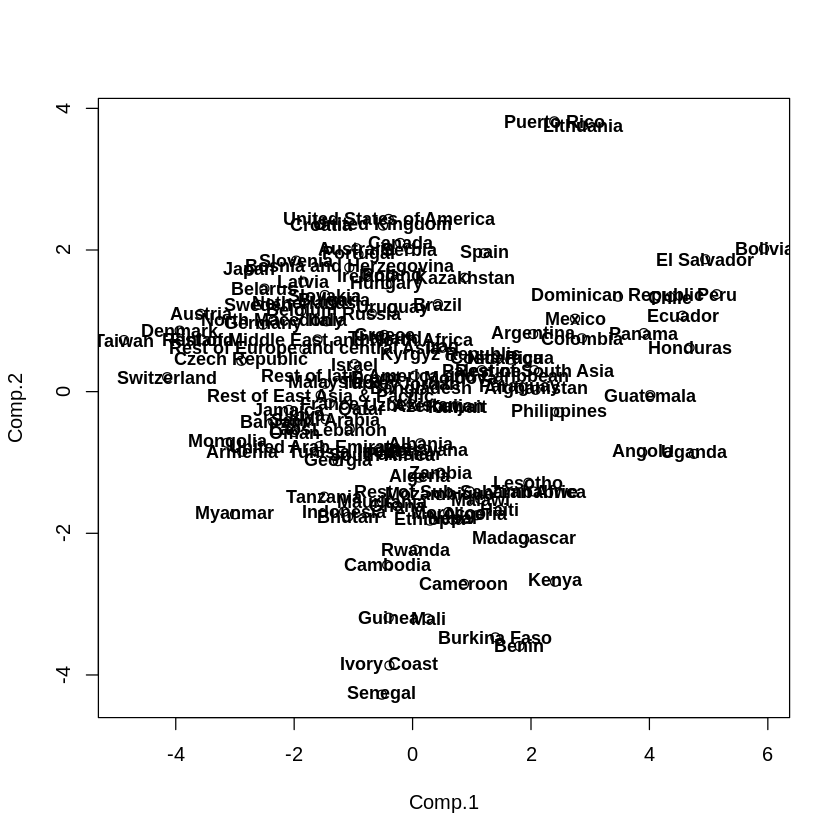

In [ ]:
plot(pca$scores[,1:2], xlim = range(pca$scores[,1]), ylim = range(pca$scores[,2]))
text(pca$scores[,1:2], labels=rownames(X), cex=0.9, font=2)

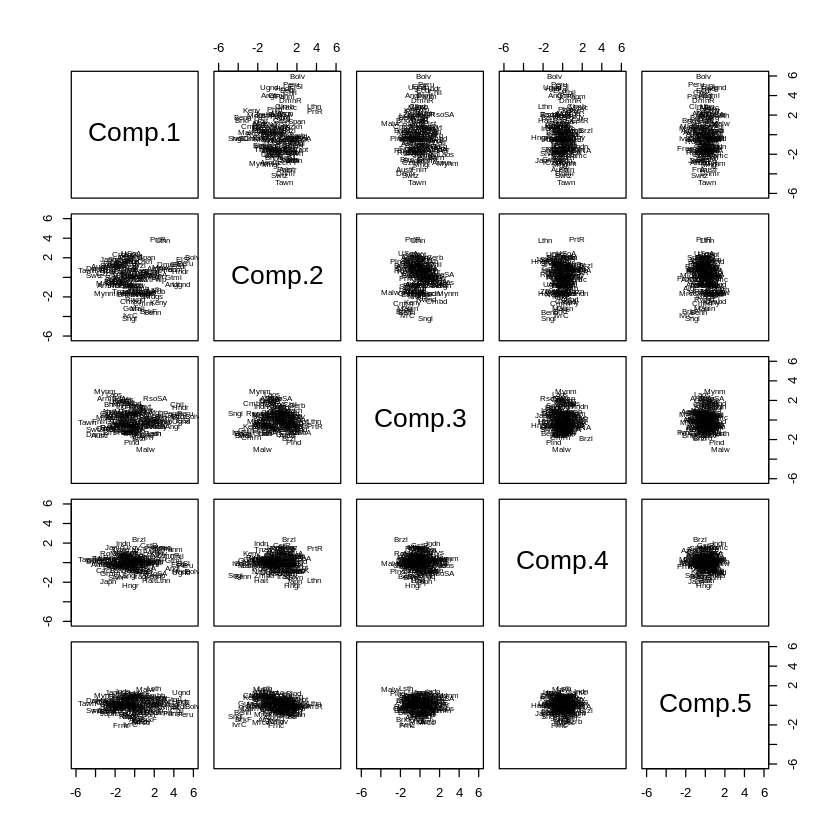

In [ ]:
pairs(pca$scores[,1:5], ylim = c(-6, 6), xlim = c(-6, 6),
    panel = function(x,y, ...) {
        text(x, y, abbreviate(row.names(X)),cex = 0.6)
    }
)

En la gráfica biplot podemos observar de manera gráfica algunos de los comentarios que se hicieron al observr los pesos de las componentes principales.

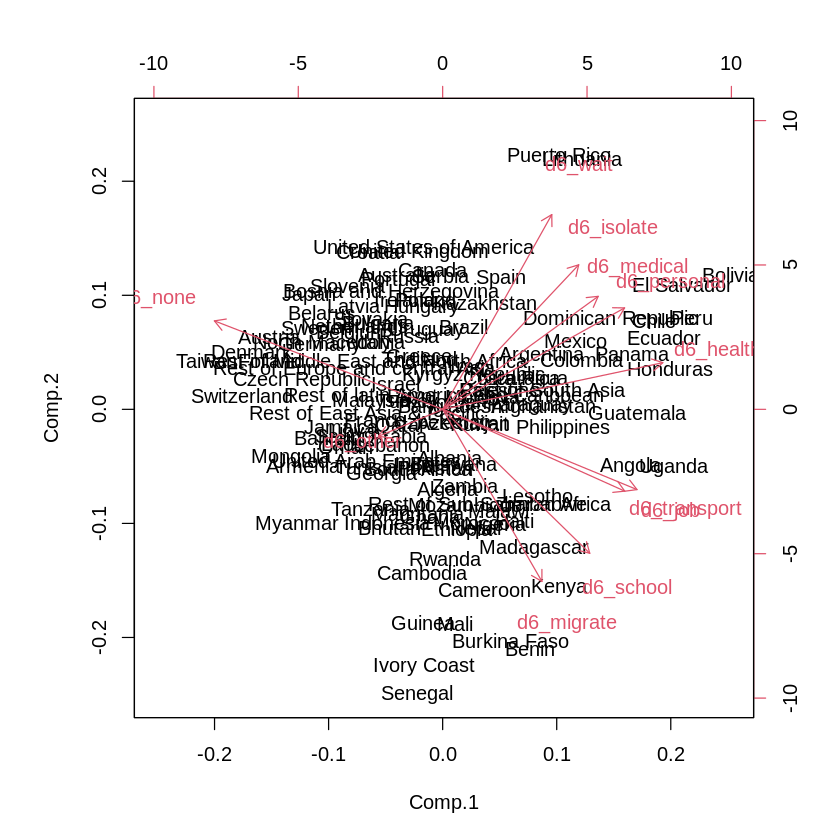

In [ ]:
biplot(pca)

## SOM
Se hicieron experimentos con diferentes tamaños de rejilla. En todos se puede apreciar que

* Celdas de esquina inferior izquierda poseen valores altos en variables `d6_health` hasta `d6_medical`, junto con variable `d6_personal` y `d6_wait`.
* Celdas en esquina superior izquierda poseen valores altos en `d6_schoool`, `d6_migrate` y `d6_job`.
* Celdas en esquina superior derecha poseen valores altos en `d6_other`.
* Celdas en esquiba inferior derecha poseen valores altos en variables `d6_none` y `d6_wait`.
* Celdas cerca del centro de la rejilla tienen valores distribuidos de manera uniforme.

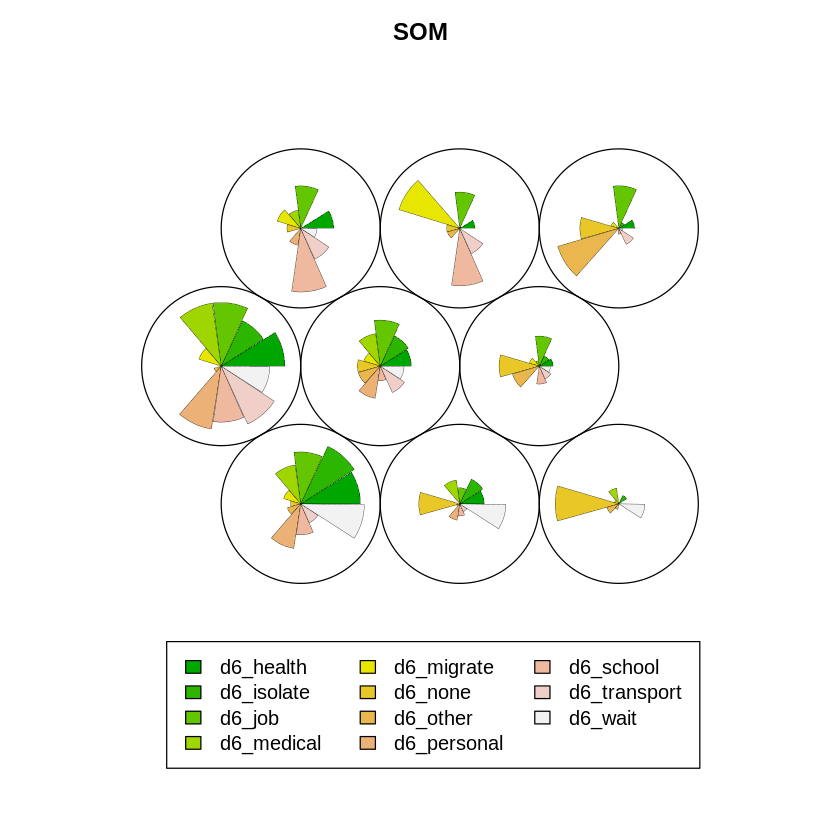

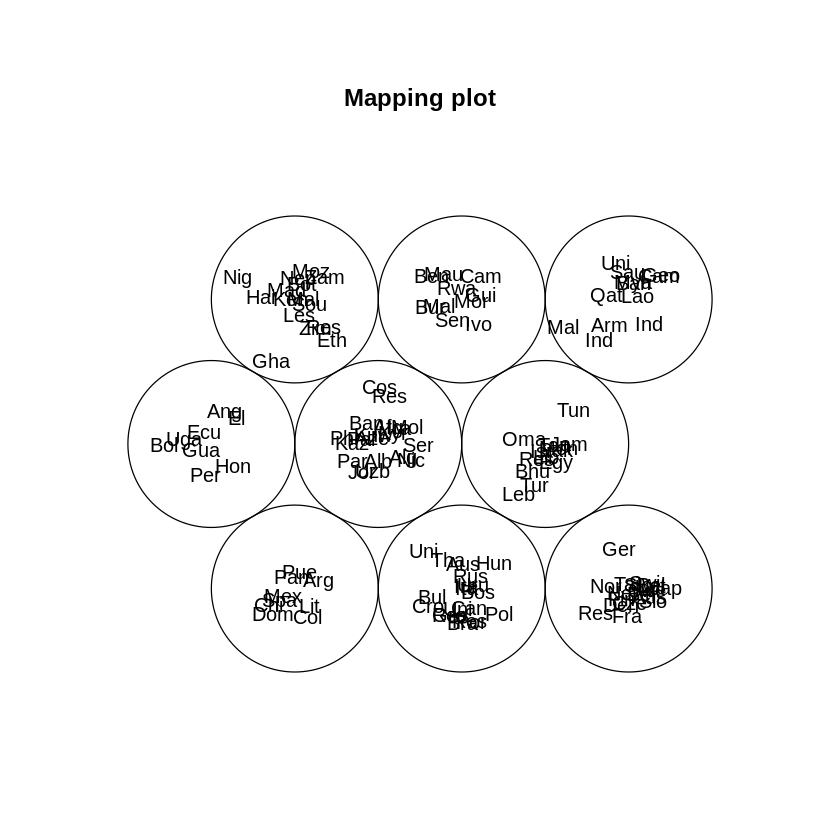

In [ ]:
library("kohonen")

set.seed(123)
s <- som(scale(X), grid = somgrid(3, 3, "hexagonal"))
plot(s, main="SOM")
plot(s,type="mapping",label=substring(row.names(X),1,3))

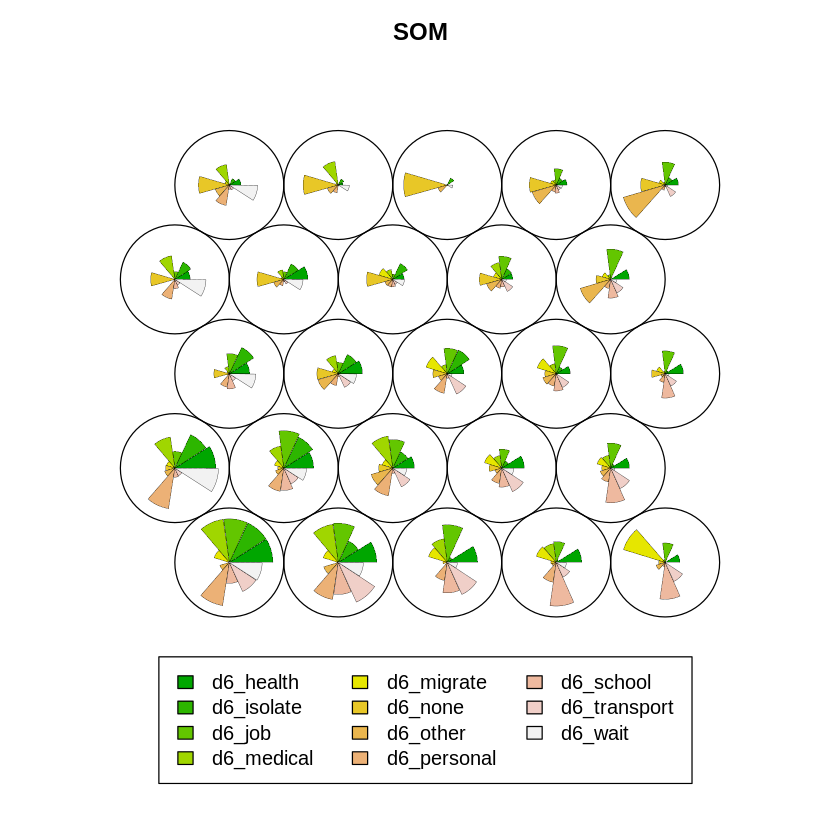

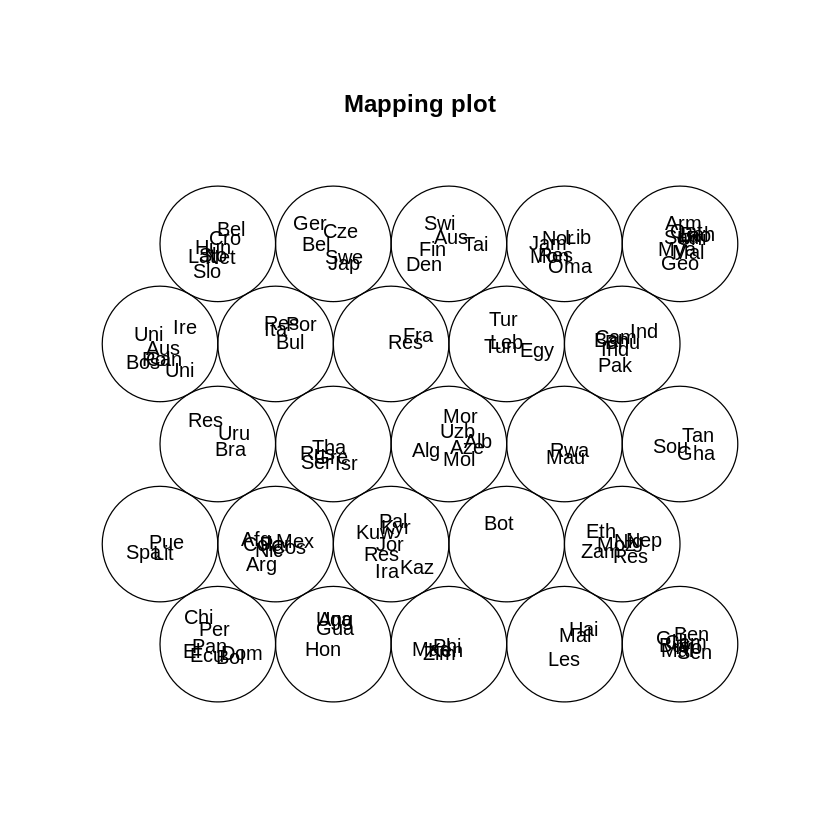

In [ ]:
set.seed(123)
s <- som(scale(X), grid = somgrid(5, 5, "hexagonal"))
plot(s, main="SOM")
plot(s,type="mapping",label=substring(row.names(X),1,3))

# Agrupamiento

## Agrupamiento Jerárquico

### Agrupamiento por regiones del mundo (7 Regiones)
Intentamos agrupar los paises por regiones con auyuda del agrupamiento jerárquico.

* Observamos que el cluster azul (3 cluster) se logran agrupar países de Latinoamérica.


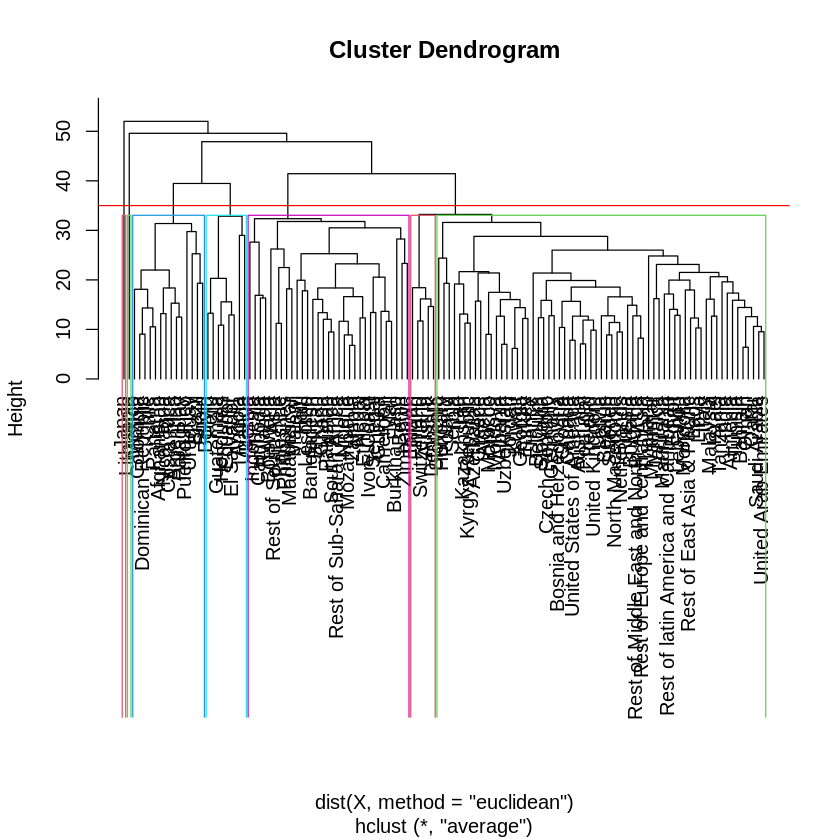

In [ ]:
h_average <-hclust(dist(X, method="euclidean"), method="average")
plot(h_average, hang=-1)
# Existe un total de 7 regiones en el mundo
rect.hclust(h_average , k = 7, border = 2:6)
abline(h = 35, col = 'red')

## Experimentación con agrupamientos

* Agrupando en dos grupos nos quedamos son datos atípicos en un grupo mientras que en el otro se quedan los datos restantes.
* Agrupando en tres grupos nos quedamos con datos atípicos en dos grupos, mientras que los otros dos grupos parecen pertenecer uno a países de Latinoamérica, mientras que el otro al resto del mundo.

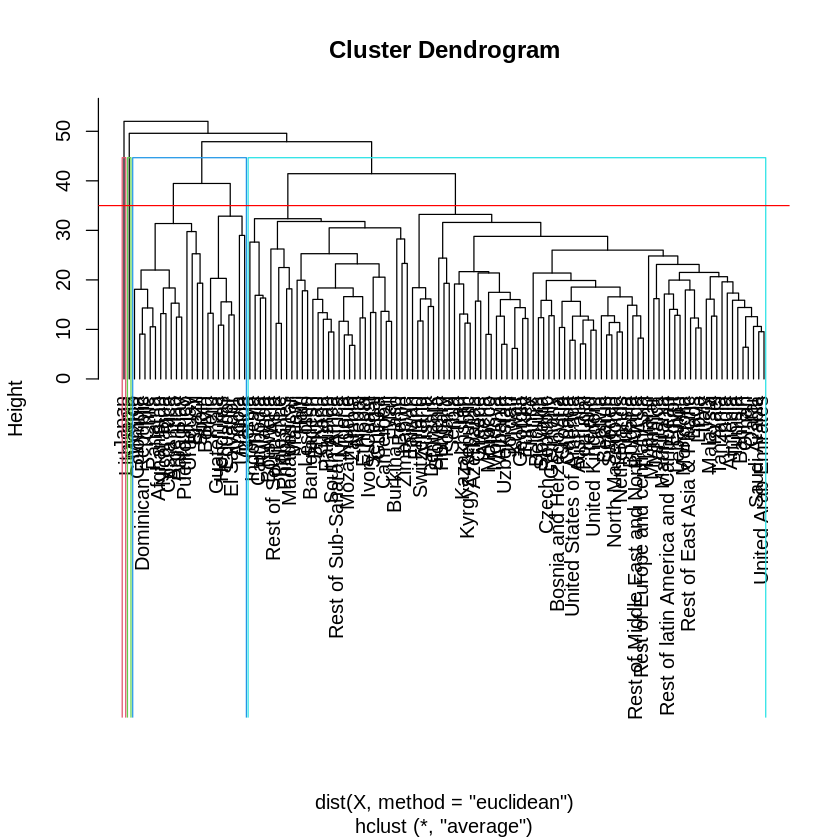

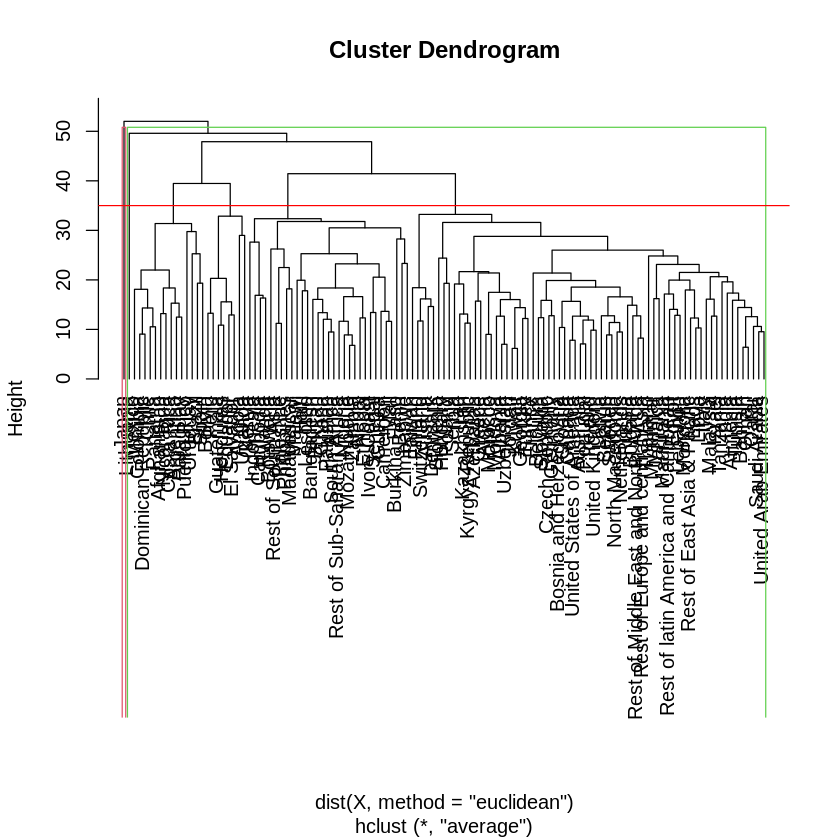

In [ ]:
h_average <-hclust(dist(X, method="euclidean"), method="average")
plot(h_average, hang=-1)
rect.hclust(h_average , k = 4, border = 2:6)
abline(h = 35, col = 'red')

h_average <-hclust(dist(X, method="euclidean"), method="average")
plot(h_average, hang=-1)
rect.hclust(h_average , k = 2, border = 2:6)
abline(h = 35, col = 'red')

# ¿Qué podemos hacer para entender mejor las diferencias en las respuestas por género (Usando lo que hemos visto)?

Una vez que hemos analizado el subconjuto de datos relacionado con los hombres, hemos conseguido encontrar propiedades interesantes por lo que podemos proseguir a hacer lo mismo con el subconjunto de datos de las mujeres para posteriormente comparar propiedades de ambos subconjuntos de datos. Por otro lado, también se puede esperar no encontrar diferencias relevantes.

* Podemos empezar comparando las medias, varianzas y matrices de correlación de ambos conjuntos, tratando de encontrar diferencias en proporciones de experimentación de fenomenos derivados por la pandemia por género, en la actividad que más experimentó un género u otro, o bien, si las variables se correlacionan de manera diferente. 

* Luego, podemos comparar las gráficas por parejas de variables. En esta sección notamos la presencia de datos atípicos, por lo que podemos buscar los mismos datos en el conjunto de mujeres, para ver si estos datos sólo son diferentes en la población de hombres. 

* Con ayuda de estas mismas graficas podemos comparar la situación de hombres y mujeres por región del mundo.

* Al hacer PCA podemos comparar los pesos de cada variable en cada componente principal, buscando diferencias significativas en la proporción de aportación de cada variable en cada conjunto de personas.

Otra opción interesante podría ser combinar ambos conjuntos conjuntos de datos y hacer un análisis de ambos datos combinados.

# Ejemplos
